In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-alpha0
        !pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)


TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [0]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

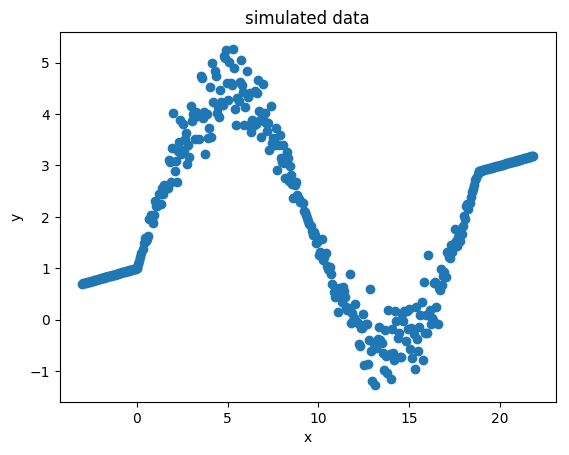

In [4]:
## use custom function to simulate some data 
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

## TFP aleatoric

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_aleatoric = Model(inputs=inputs, outputs=dist)
model_aleatoric.compile(Adam(), loss=NLL) 

In [6]:
model_aleatoric.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
___________________________________________________________

In [0]:
history = model_aleatoric.fit(x, y, epochs=1500, verbose=0,batch_size=32)

In [0]:
model_aleatoric_mean = Model(inputs=inputs, outputs=dist.mean())
model_aleatoric_sd = Model(inputs=inputs, outputs=dist.stddev())

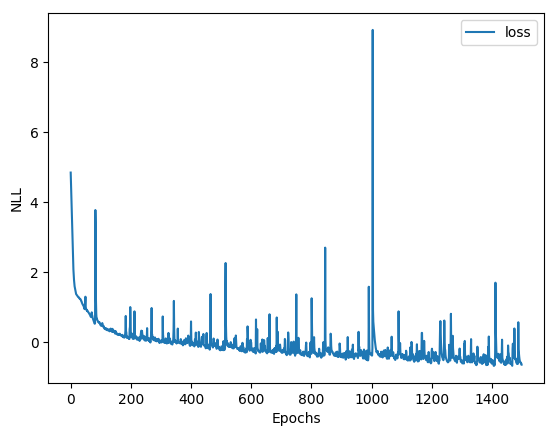

In [9]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

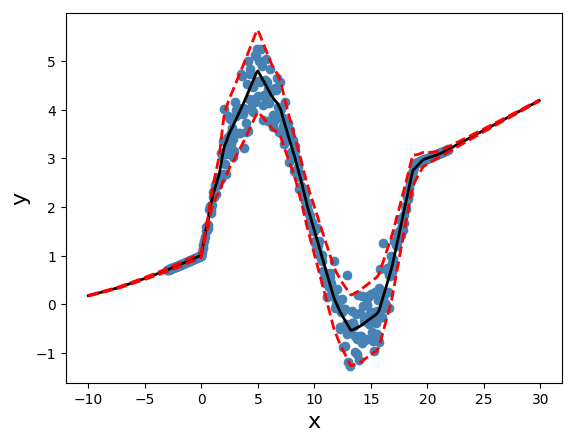

In [10]:

x_pred = np.arange(-10,30,0.1)

plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()


## TFP aleatoric and epistemic

In [0]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(my_dist)(params) 


model_aleatoic_epistemic = Model(inputs=inputs, outputs=dist)
model_aleatoic_epistemic.compile(Adam(), loss=NLL) 

In [16]:
model_aleatoic_epistemic.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout_4 (DenseFlipou (None, 20)                80        
_________________________________________________________________
dense_flipout_5 (DenseFlipou (None, 50)                2100      
_________________________________________________________________
dense_flipout_6 (DenseFlipou (None, 20)                2040      
_________________________________________________________________
dense_flipout_7 (DenseFlipou (None, 2)                 84        
_________________________________________________________________
distribution_lambda_2 (Distr ((None, 1), (None, 1))    0         
Total params: 4,304
Trainable params: 4,304
Non-trainable params: 0
_________________________________________________________

In [0]:
history = model_aleatoic_epistemic.fit(x, y, epochs=3000, verbose=0,batch_size=32)

In [0]:
model_aleatoric_epistemic_mean = Model(inputs=inputs, outputs=dist.mean())
model_aleatoric_epistemic_sd = Model(inputs=inputs, outputs=dist.stddev())

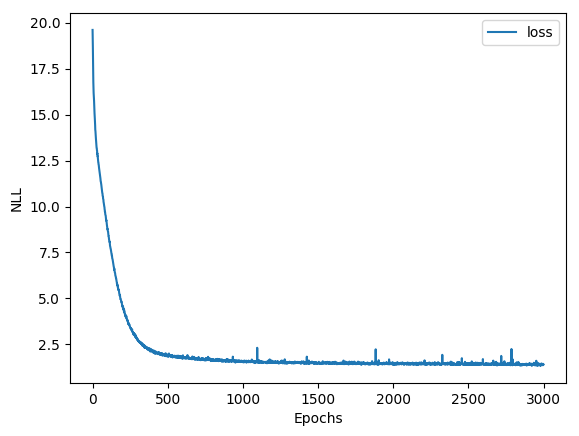

In [19]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

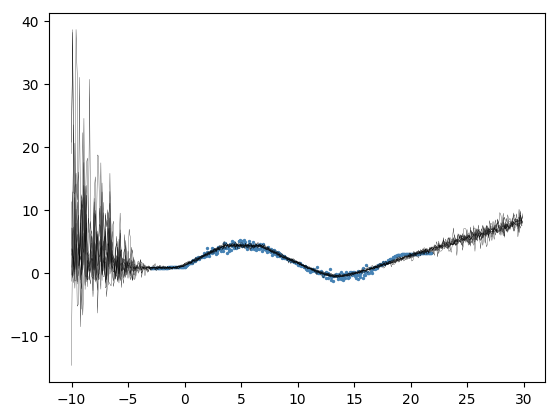

In [20]:
plt.scatter(x,y,color="steelblue",s=2) #observerd 
for i in range(0,10):
  plt.plot(x_pred,np.reshape(model_aleatoric_epistemic_mean.predict(x_pred),len(x_pred)),color="black",linewidth=0.2)
  #plt.ylim([-10,10])


In [21]:
x_pred = np.arange(-10,30,0.1)
n=1000
n_preds=np.zeros((n,len(x_pred)))
n_preds_std=np.zeros((n,len(x_pred)))

for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model_aleatoric_epistemic_mean.predict(x_pred),len(x_pred))
  n_preds_std[i,:]=np.reshape(model_aleatoric_epistemic_sd.predict(x_pred),len(x_pred))

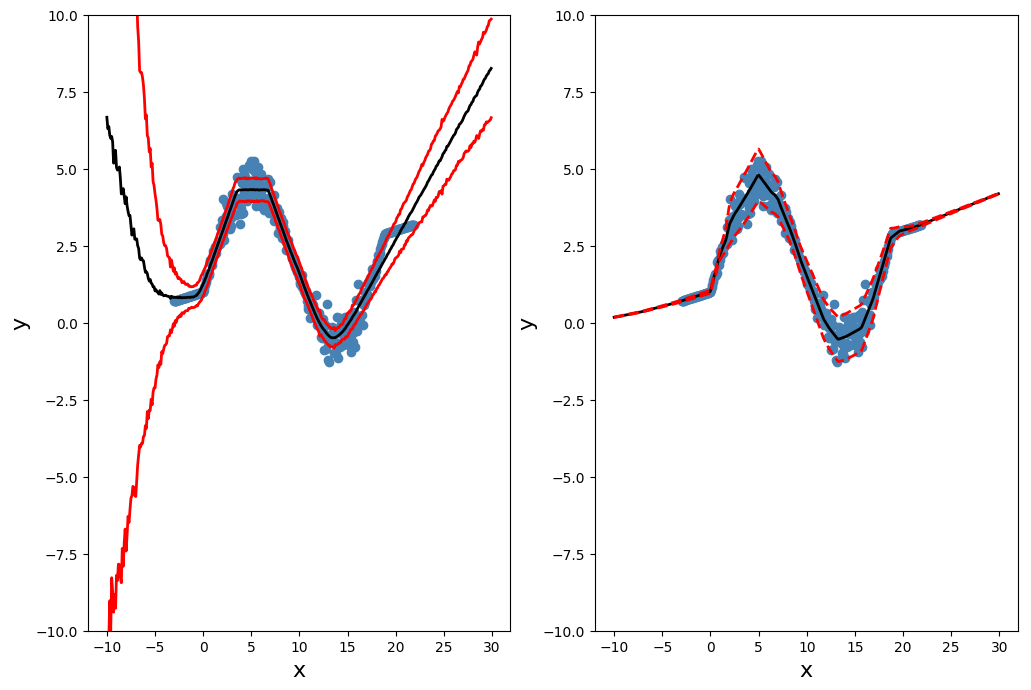

In [22]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="red",linewidth=2)
plt.plot(x_pred,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="red",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.ylim([-10,10])


plt.subplot(1,2,2)
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.ylim([-10,10])
plt.show()


## MC Dropout

In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
#we need to disable the eager execution to do multiple mc runs

In [0]:
from tensorflow.keras.layers import Dropout


inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden)
hidden = Dense(20,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden)
out = Dense(1)(hidden)

model_mc = Model(inputs=inputs, outputs=out)
model_mc.compile(Adam(), loss="mean_squared_error") 

In [25]:
model_mc.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                40        
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0   

In [0]:
history = model_mc.fit(x, y, epochs=4000, verbose=0,batch_size=32)

Text(0.5, 0, 'Epochs')

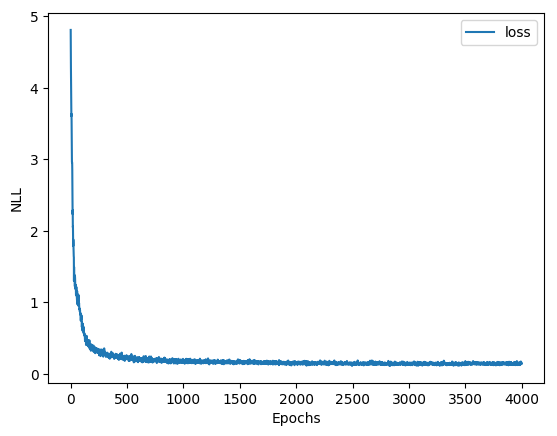

In [27]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [0]:
import tensorflow.keras.backend as K
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])

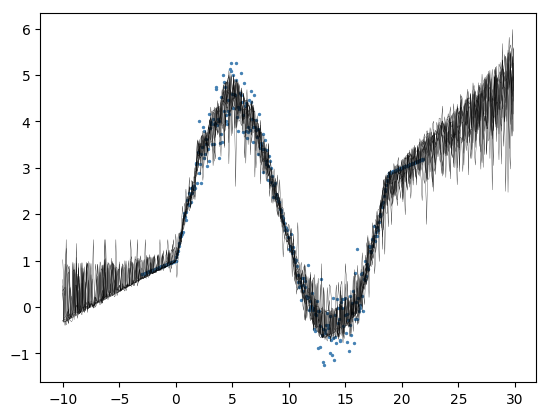

In [29]:
#deep 5 layer 1024 and low rate=01
plt.scatter(x,y,color="steelblue",s=2) #observerd 
for i in range(0,10):
  plt.plot(x_pred,np.squeeze(model_mc_pred([np.expand_dims(x_pred,axis=1),1])),color="black",linewidth=0.2)


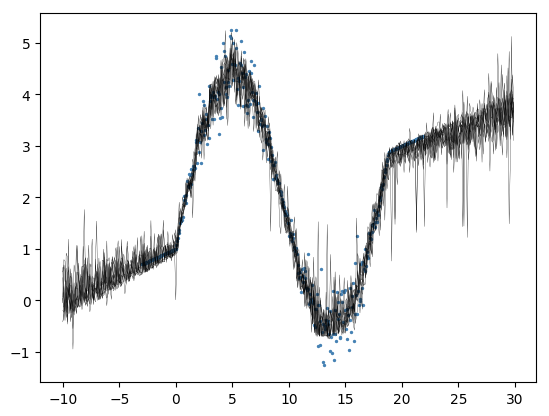

In [230]:
plt.scatter(x,y,color="steelblue",s=2) #observerd 
for i in range(0,10):
  plt.plot(x_pred,np.squeeze(model_mc_pred([np.expand_dims(x_pred,axis=1),1])),color="black",linewidth=0.2)


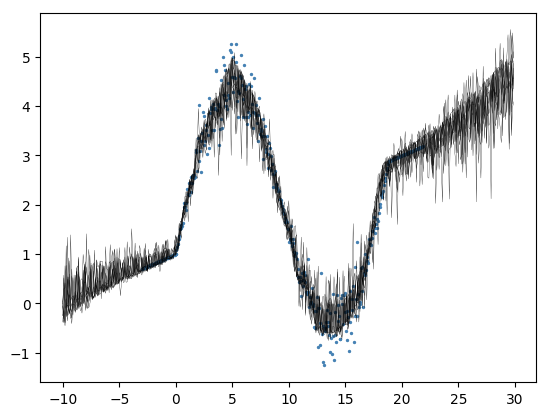

In [221]:
plt.scatter(x,y,color="steelblue",s=2) #observerd 
for i in range(0,10):
  plt.plot(x_pred,np.squeeze(model_mc_pred([np.expand_dims(x_pred,axis=1),1])),color="black",linewidth=0.2)


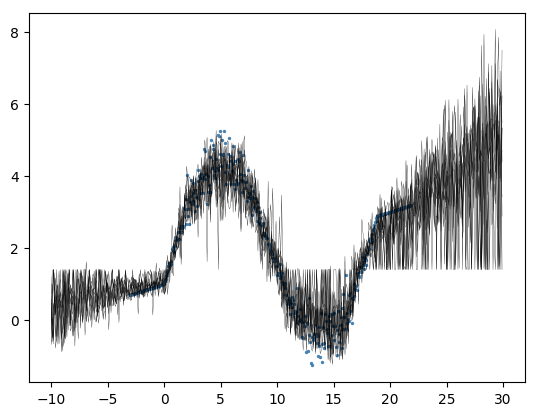

In [188]:
plt.scatter(x,y,color="steelblue",s=2) #observerd 
for i in range(0,10):
  plt.plot(x_pred,np.squeeze(model_mc_pred([np.expand_dims(x_pred,axis=1),1])),color="black",linewidth=0.2)


In [30]:
n=500
n_preds=np.zeros((n,len(x_pred)))
n_preds_std=np.zeros((n,len(x_pred)))

for i in tqdm(range(0,n)):
  n_preds[i,:]=np.squeeze(model_mc_pred([np.expand_dims(x_pred,axis=1),1]))
  n_preds_std[i,:]=np.squeeze(model_mc_pred([np.expand_dims(x_pred,axis=1),1]))

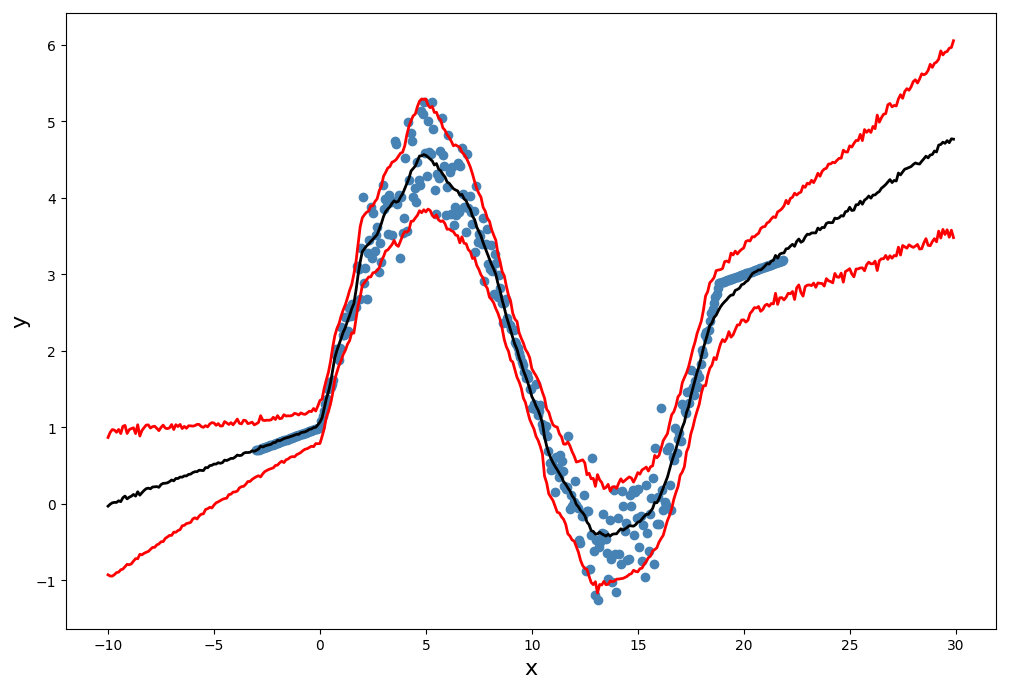

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="red",linewidth=2)
plt.plot(x_pred,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="red",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()


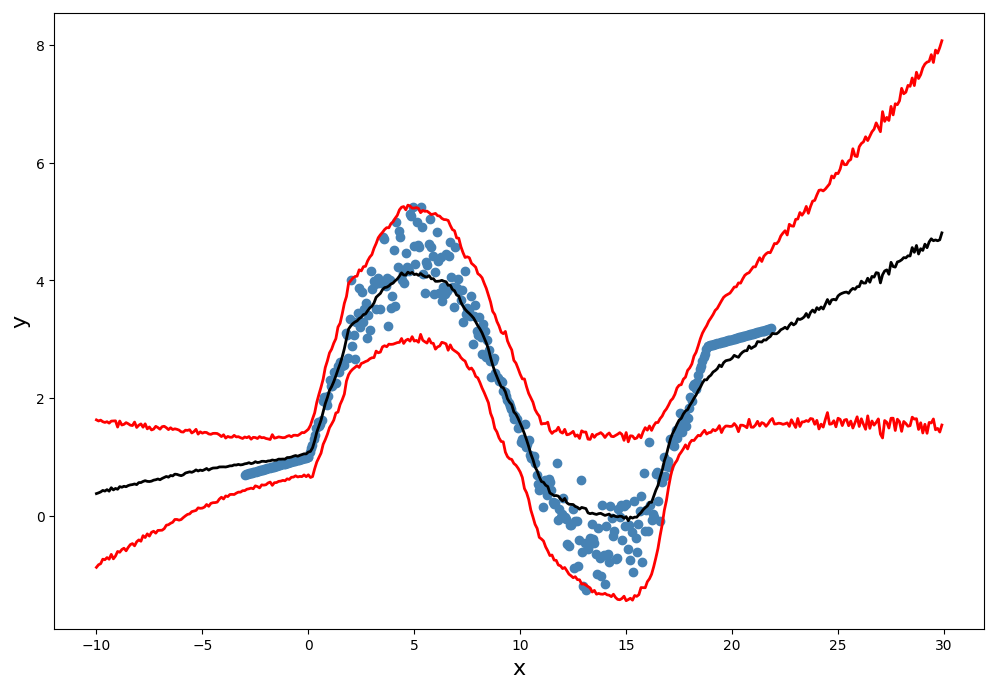

In [190]:
plt.figure(figsize=(12,8))
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="red",linewidth=2)
plt.plot(x_pred,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="red",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()
